In [1]:
from Model_Training import *
from Cleaner import Cleaner
import plotly.express as px
import warnings
import pandas as pd
from EmpiricDistribution import EmpiricDistribution
from datetime import datetime, time
import pickle # Para guardar los modelos entrenados
from datetime import time 
import matplotlib.pyplot as plt
import numpy as np
import random
from sympy import Symbol
from datetime import time
import random

warnings.filterwarnings('ignore')

buses_model = Buses()
pax_model = PAX()

### Buses

In [ ]:
#Uncomment this line if you dont have the time_models.pkl

#buses_model.generate_model()

Iniciando modelado de la distribución de Tiempos de Viaje...
Error: No valid symbolic solution found (likely m=0) for interval 10. Using x_max as inverse.
Error: No valid symbolic solution found (likely m=0) for interval 13. Using x_max as inverse.
Error: No valid symbolic solution found (likely m=0) for interval 14. Using x_max as inverse.
  -> Modelo de Tiempo A2-GLAXO_0700-0930 entrenado.
Error: No valid symbolic solution found (likely m=0) for interval 13. Using x_max as inverse.
Error: No valid symbolic solution found (likely m=0) for interval 14. Using x_max as inverse.
  -> Modelo de Tiempo A2-GLAXO_1330-1800 entrenado.
  -> Modelo de Tiempo A2-GLAXO_0600-0700 entrenado.
Error: No valid symbolic solution found (likely m=0) for interval 9. Using x_max as inverse.
Error: No valid symbolic solution found (likely m=0) for interval 10. Using x_max as inverse.
Error: No valid symbolic solution found (likely m=0) for interval 11. Using x_max as inverse.
Error: No valid symbolic solutio

In [ ]:
#Uncomment this line if you dont have the bus_results_times.csv
#buses_model.generate_simulation(n_samples=2000)

Modelos de tiempo cargados correctamente.

Iniciando simulación de Monte Carlo (Solo Tiempos) con 2000 iteraciones...
  -> Segmento A2-GLAXO_0700-0930 simulado con 2000 muestras.
  -> Segmento A2-GLAXO_1330-1800 simulado con 2000 muestras.
  -> Segmento A2-GLAXO_0600-0700 simulado con 2000 muestras.
  -> Segmento A2-GLAXO_0930-1330 simulado con 2000 muestras.
  -> Sustitución TIEMPO en A2-GLAXO_1830-2215: Usando proxy A2-GLAXO_0600-0700.
  -> Segmento GLAXO-DISNEY_0700-0930 simulado con 2000 muestras.
  -> Segmento GLAXO-DISNEY_1330-1800 simulado con 2000 muestras.
  -> Segmento GLAXO-DISNEY_0600-0700 simulado con 2000 muestras.
  -> Segmento GLAXO-DISNEY_0930-1330 simulado con 2000 muestras.
  -> Sustitución TIEMPO en GLAXO-DISNEY_1830-2215: Usando proxy A2-GLAXO_0600-0700.
  -> Segmento DISNEY-A2_0700-0930 simulado con 2000 muestras.
  -> Segmento DISNEY-A2_1330-1800 simulado con 2000 muestras.
  -> Segmento DISNEY-A2_0600-0700 simulado con 2000 muestras.
  -> Segmento DISNEY-A2_0930

Iniciando generación de 15 histogramas de tiempo...


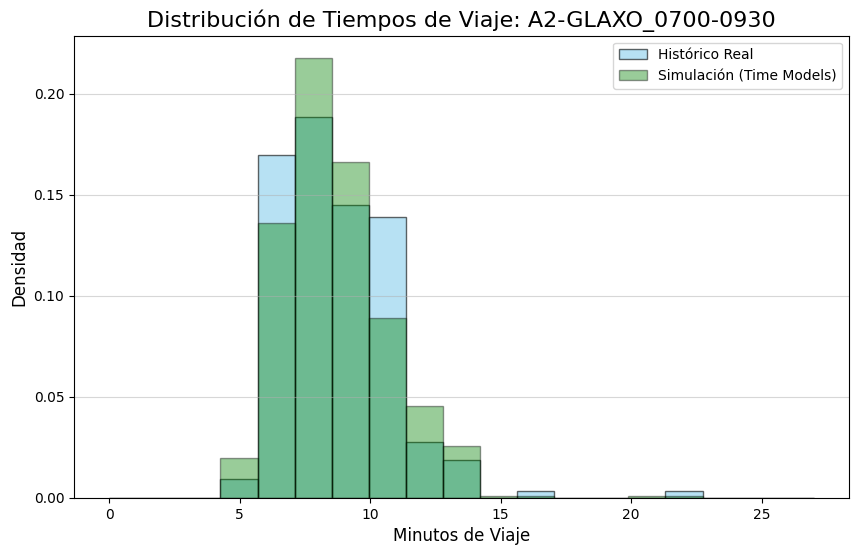

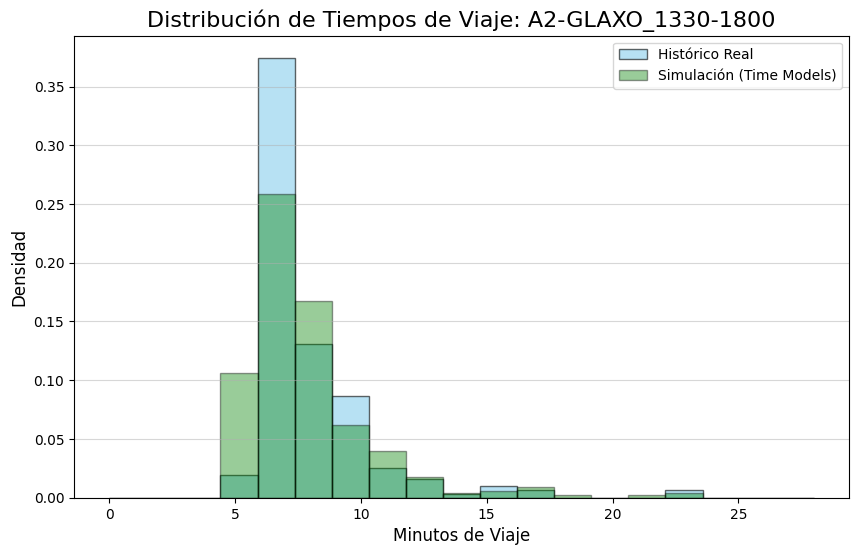

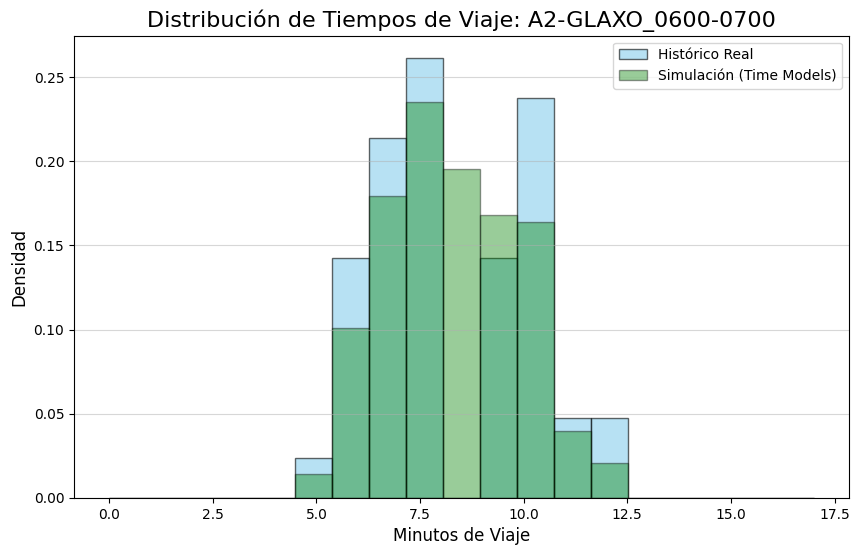

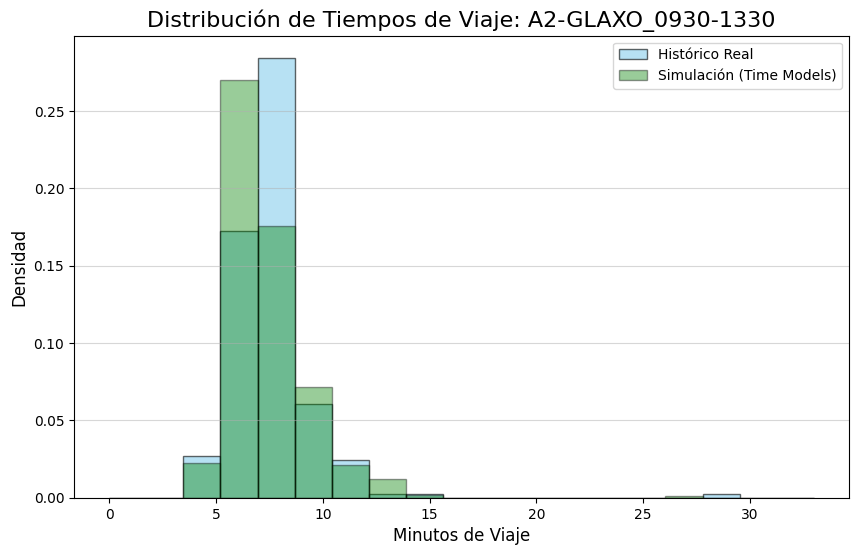

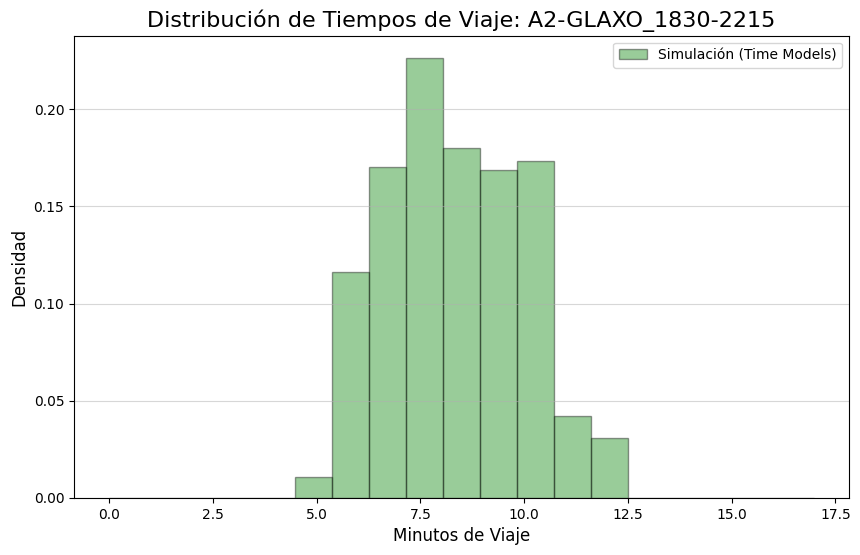

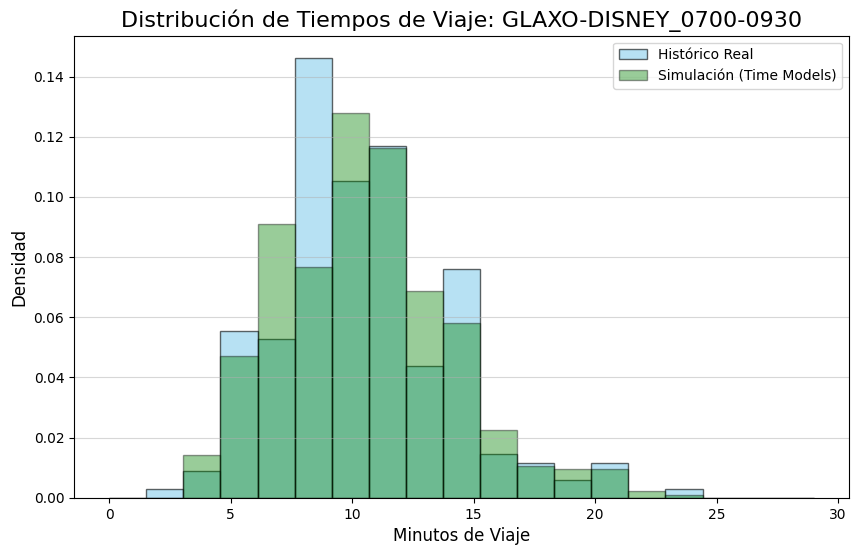

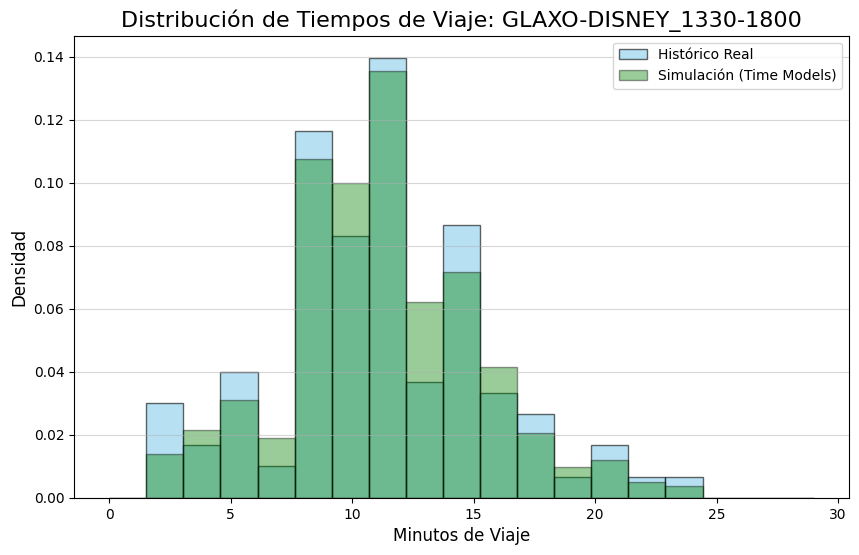

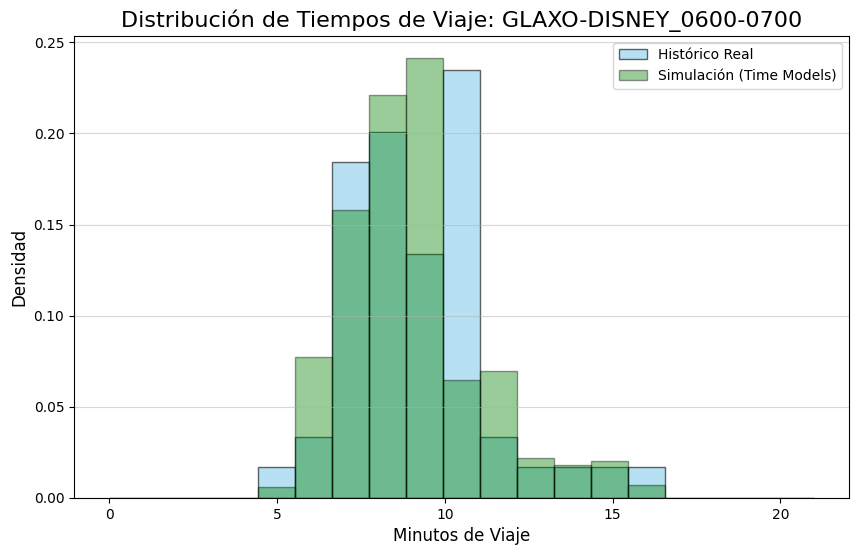

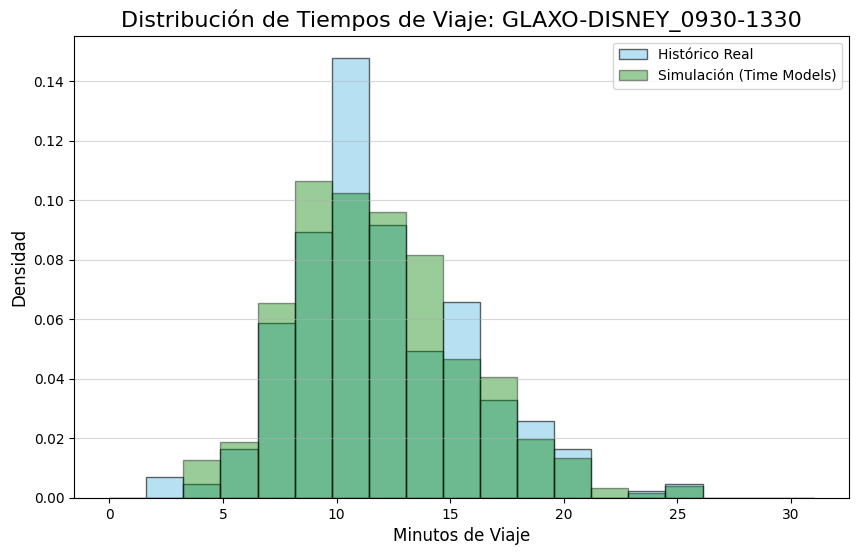

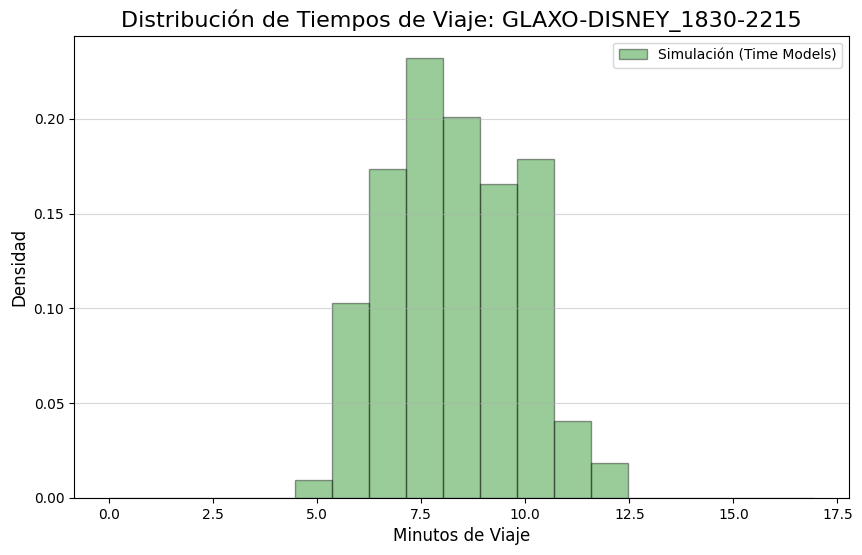

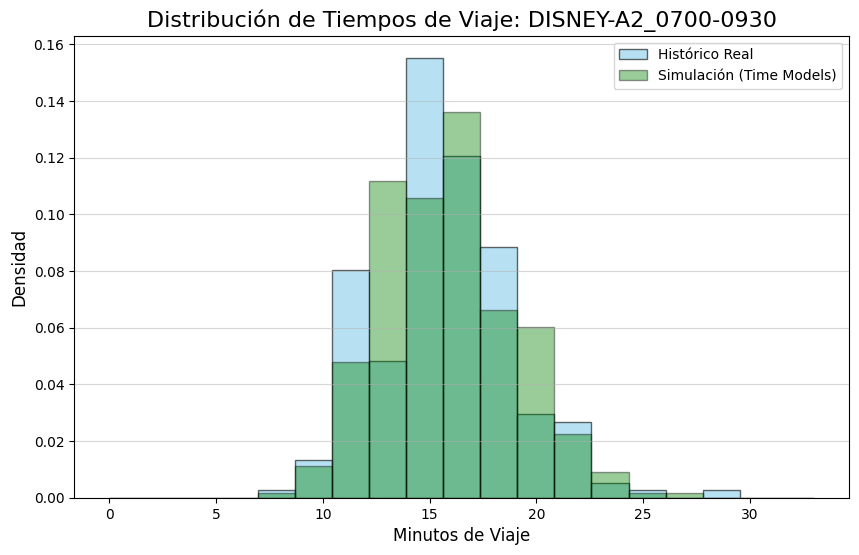

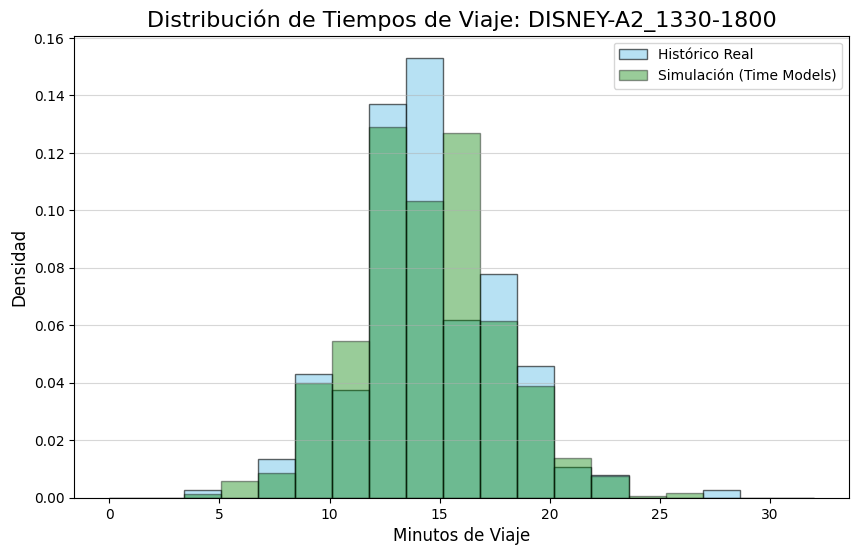

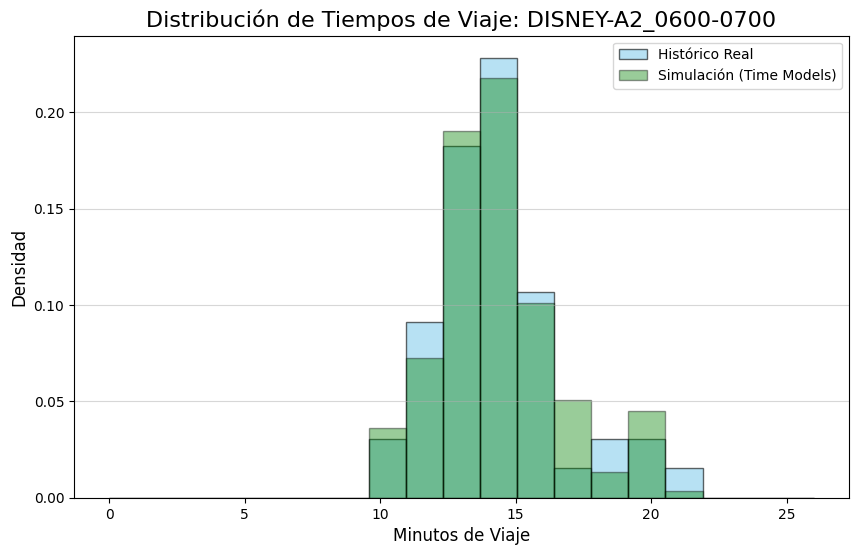

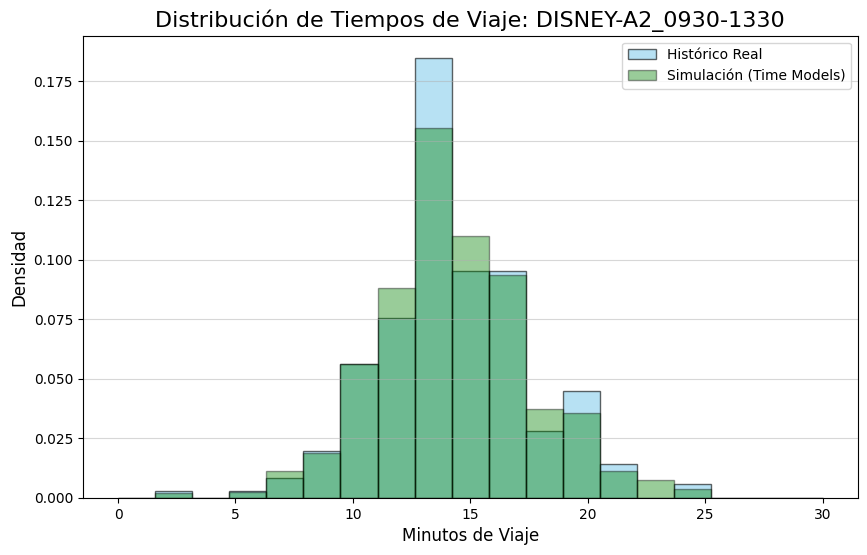

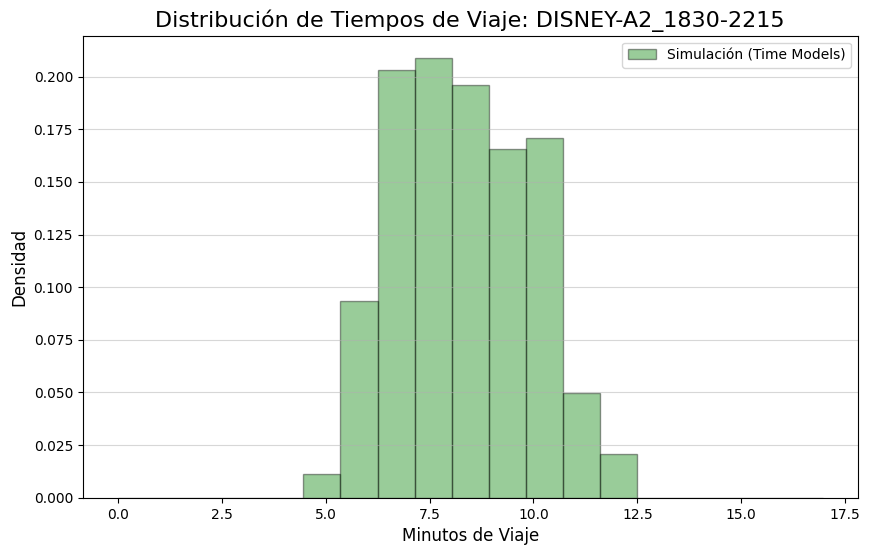

In [2]:
#Show histograms of real data vs simulated data (to validate model)

buses_model.show_results()

### PAX

In [3]:
pax_model.generate_model(n_buses=2)

In [4]:
pax_model.generate_simulation(n_samples=10000)

### DISCRETE SIMULATION